# MNIST Comparison

---
## Setup Instructions

Before running this notebook, ensure you have the dataset ready. You have two options:

1. **Automatic Download**: Run `setup.ipynb`, which will retrieve the data directly from Kaggle.
2. **Manual Download**: Retrieve the dataset manually from [Kaggle's Digit Recognizer competition](https://www.kaggle.com/competitions/digit-recognizer) and extract the files into the `data/input` folder.

---

## Overview

This notebook explores **training a neural network on the MNIST dataset** using **PyTorch** and **TurbaNet**, a framework for training multiple models concurrently. Our primary objectives include:

- Training a **baseline PyTorch model** and evaluating its performance using a confusion matrix.
- Training a **swarm of TurbaNet models** on the MNIST dataset.
- Comparing the performance of PyTorch and TurbaNet models.
- Demonstrating that **TurbaNet can train multiple models in the same time PyTorch takes to train a single model**, leveraging vectorization when memory constraints allow.

---

## Model Training Approach

#### **Control Model (PyTorch)**
We start with a standard neural network trained using PyTorch. The model will be evaluated based on **accuracy** and **loss metrics**.

#### **Swarm-Based Training (TurbaNet)**
Next, we employ TurbaNet to train multiple models **simultaneously**. This swarm-based approach aims to maximize **computational efficiency** while maintaining high accuracy.

#### **Performance Comparison**
After training, we will:
- Compare the confusion matrices of both approaches.
- Analyze batch-wise accuracy and loss trends.
- Evaluate the real-time efficiency of TurbaNet compared to traditional training methods.


In [883]:
import time

import matplotlib.pyplot as plt
import numpy as np
import optax
import pandas as pd
import seaborn as sns
import torch

from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from turbanet import TurbaTrainState

In [884]:
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = True

---
# Hyperparameters

We define key hyperparameters for training our models, here is an example of a configuration:

- **EPOCHS = 10** → Train for 10 full passes over the dataset.
- **SWARM_SIZE = 5** → Train 5 models concurrently using TurbaNet.
- **BATCH_SIZE = 32** → Process 32 images per training batch.
- **BOOTSTRAP_SIZE = 2,000** -> Draw 2,000 samples from the dataset for each model in the swarm - if None, the entire dataset is used
- **LR = 5e-5** → Learning rate set to `0.00005` for stable convergence.
- **CPU = True** → Force PyTorch to use the CPU instead of the GPU. 
    - This can be helpful for comparing performance of the libraries when running on Windows machines as [Jax does not support GPUs running on Windows](https://docs.jax.dev/en/latest/installation.html).
- **HIDDEN1 = 64**, **HIDDEN2 = 32** → Two-layer neural network with 64 and 32 neurons, respectively.

These settings balance **training stability** and **efficiency**, leveraging **swarm-based training** to speed up model convergence.

Feel free to tweak this values and examine the impact on training speed and effectivity.

## Training Parameters

In [885]:
EPOCHS = 10
SWARM_SIZE = 50
BATCH_SIZE = 8
BOOTSTRAP_SIZE = None
LR = 5e-5
CPU = False

## Model Parameters

In [886]:
HIDDEN1 = 64
HIDDEN2 = 32

---
# Data Collection

Before training our models, we need to **load and preprocess** the MNIST dataset.

### Steps:
1. **Load the Dataset**: We will use the data provided from [Kaggle's Digit Recognizer competition](https://www.kaggle.com/competitions/digit-recognizer) (see note at the top of this notebook for instructions on how to get this data).
2. **Normalize the Data**: Convert images to tensors and normalize pixel values to the range `[0, 1]`.
3. **Split into Training & Test Sets**: Ensure proper data segregation for model evaluation.


In [887]:
# Reading the data
train_df = pd.read_csv("../../data/input/train.csv")
test_df = pd.read_csv("../../data/input/test.csv")
print(train_df.shape, test_df.shape)
print("Train Cols : ", train_df.columns)
print("Test Cols : ", test_df.columns)
print(" Label -  ", [i for i in train_df.columns if i not in test_df.columns])

(42000, 785) (28000, 784)
Train Cols :  Index(['label', 'pixel0', 'pixel1', 'pixel2', 'pixel3', 'pixel4', 'pixel5',
       'pixel6', 'pixel7', 'pixel8',
       ...
       'pixel774', 'pixel775', 'pixel776', 'pixel777', 'pixel778', 'pixel779',
       'pixel780', 'pixel781', 'pixel782', 'pixel783'],
      dtype='object', length=785)
Test Cols :  Index(['pixel0', 'pixel1', 'pixel2', 'pixel3', 'pixel4', 'pixel5', 'pixel6',
       'pixel7', 'pixel8', 'pixel9',
       ...
       'pixel774', 'pixel775', 'pixel776', 'pixel777', 'pixel778', 'pixel779',
       'pixel780', 'pixel781', 'pixel782', 'pixel783'],
      dtype='object', length=784)
 Label -   ['label']


In [888]:
train_df.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [889]:
# Checking the distribution of the labels
train_df["label"].value_counts().sort_index()

label
0    4132
1    4684
2    4177
3    4351
4    4072
5    3795
6    4137
7    4401
8    4063
9    4188
Name: count, dtype: int64

In [890]:
# Convert df to numpy array
images = np.array(train_df.iloc[:, 1:])

In [891]:
images.shape

(42000, 784)

In [892]:
# Scaling the image so that the values only range between 0 and 1
images = images / 255.0

In [893]:
# Convert labels to one-hot encoding tensor
labels = np.array(train_df["label"])
image_label = np.zeros((images.shape[0], 10))
image_label[np.arange(images.shape[0]), labels] = 1.0

In [894]:
# Splitting the dataset into train, validation and test
X_train, X_val, y_train, y_val = train_test_split(
    images, image_label, test_size=0.2, stratify=train_df["label"]
)
X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size=0.5)

In [895]:
print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)
print(X_test.shape)
print(y_test.shape)

(33600, 784)
(33600, 10)
(4200, 784)
(4200, 10)
(4200, 784)
(4200, 10)


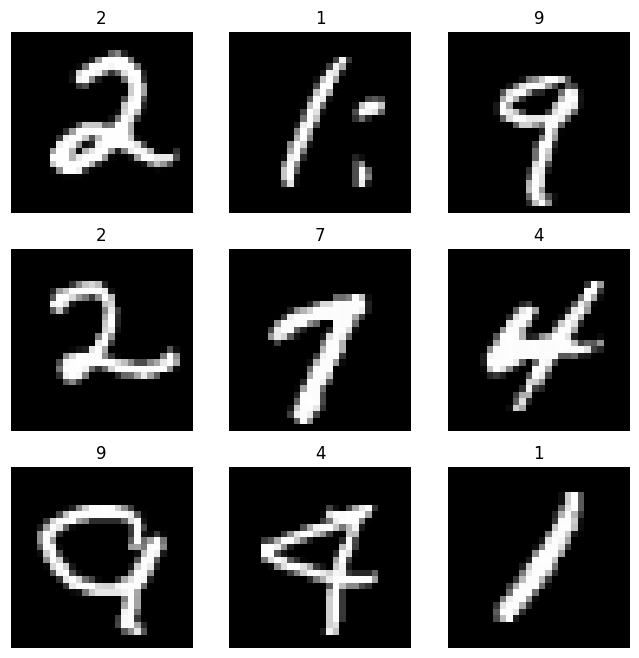

In [896]:
# Ploting some of the datapoints in the dataset
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
figure.add_subplot(rows, cols, 1)
plt.axis("off")
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(X_train), size=(1,)).item()
    sample_img = X_train[sample_idx].reshape(28, 28)
    sample_lbl = np.argmax(y_train[sample_idx])
    figure.add_subplot(rows, cols, i)
    plt.title(sample_lbl)
    plt.axis("off")
    plt.imshow(sample_img.squeeze(), cmap="gray")
plt.show()

In [897]:
# Generate batches of data
X_train = torch.Tensor(X_train)
y_train = torch.Tensor(y_train)

X_val = torch.Tensor(X_val)
y_val = torch.Tensor(y_val)

y_test = torch.Tensor(y_test)
X_test = torch.Tensor(X_test)

train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
train_dataloader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
)
val_dataloader = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(X_val, y_val), batch_size=BATCH_SIZE, shuffle=False
)
test_dataloader = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(X_test, y_test), batch_size=BATCH_SIZE, shuffle=True
)


---
# PyTorch Model Training

In this section, we implement a **baseline neural network** using PyTorch to establish a performance benchmark.

### Model Architecture:
- **Fully connected neural network** with two hidden layers.
- **ReLU activations** for non-linearity.
- **Softmax output layer** for digit classification (0-9).

### Training Details:
- **Loss Function**: Cross-Entropy Loss
- **Optimizer**: Adam

This PyTorch model serves as a **control experiment**, helping us compare its efficiency and accuracy against the **swarm-based training** approach used in TurbaNet.


In [898]:
## Checking if the GPU is being used properly.
DEVICE = torch.device("cuda" if torch.cuda.is_available() and not CPU else "cpu")
print("Using device:", DEVICE)

Using device: cuda


## Model/Optimizer/Loss Definitions

In [899]:
from torch import nn


# Softmax layer ignored since the loss function defined is nn.CrossEntropy()
class MyOwnNeuralNetwork(nn.Module):
    def __init__(self):
        super(MyOwnNeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(784, HIDDEN1),
            nn.ReLU(),
            nn.Linear(HIDDEN1, HIDDEN2),
            nn.ReLU(),
            nn.Linear(HIDDEN2, 10),
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits


torch_model = MyOwnNeuralNetwork().to(DEVICE)
print(torch_model)


MyOwnNeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=10, bias=True)
  )
)


In [900]:
## Defining optimizer and loss functions
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(torch_model.parameters(), lr=LR)

## Helper Functions

In [901]:
def pytorch_train(dataloader, model, loss_fn, optimizer):
    size = 0
    correct = 0

    batch_loss = np.zeros(len(dataloader))
    batch_accuracy = np.zeros(len(dataloader))

    for batch, (X, y) in enumerate(dataloader):
        # Feedforward / Loss
        X, y = X.to(DEVICE), y.to(DEVICE)
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backprop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Accuracy
        _correct = (pred.argmax(1) == y.argmax(1)).type(torch.float32).sum().item()

        # Updating loss_batch and batch_accuracy
        batch_loss[batch] = loss.item()
        batch_accuracy[batch] = _correct / X.shape[0]

        # Updating size and correct
        size += X.shape[0]
        correct += _correct

        if batch % 100 == 0:
            loss = loss.item()
            current = batch * X.shape[0]
            print(f"loss: {loss:>7f}  [{current:>5d}]")

    accuracy = correct / size
    print(f"Train Accuracy: {(100 * accuracy):>0.1f}%")

    return batch_loss, batch_accuracy


In [902]:
def pytorch_validation(dataloader, model, loss_fn):
    size = 0
    correct = 0

    batch_loss = np.zeros(len(dataloader))
    batch_accuracy = np.zeros(len(dataloader))
    with torch.no_grad():
        for batch, (X, y) in enumerate(dataloader):
            # Feedforward / Loss
            X, y = X.to(DEVICE), y.to(DEVICE)
            pred = model(X)
            loss = loss_fn(pred, y)

            # Accuracy
            _correct = (pred.argmax(1) == y.argmax(1)).type(torch.float32).sum().item()

            # Updating loss_batch and batch_accuracy
            batch_loss[batch] = loss.item()
            batch_accuracy[batch] = _correct / X.shape[0]

            # Updating size and correct
            size += X.shape[0]
            correct += _correct

    accuracy = correct / size
    print(f"Validation Accuracy: {(100 * accuracy):>0.1f}%")

    return batch_loss, batch_accuracy

## Training

In [903]:
start = time.time()
train_batch_loss = []
train_batch_accuracy = []
train_epoch_no = []

for t in range(EPOCHS):
    print(f"\nEpoch {t + 1}\n-------------------------------")
    torch_model.train()
    _train_batch_loss, _train_batch_accuracy = pytorch_train(
        train_dataloader, torch_model, loss_fn, optimizer
    )

    torch_model.eval()
    _valid_batch_loss, _valid_batch_accuracy = pytorch_validation(
        val_dataloader, torch_model, loss_fn
    )

    for i in range(len(_train_batch_loss)):
        train_batch_loss.append(_train_batch_loss[i])
        train_batch_accuracy.append(_train_batch_accuracy[i])
        train_epoch_no.append(t + float((i + 1) / len(_train_batch_loss)))

    if t == 0:
        valid_batch_loss = _valid_batch_loss
        valid_batch_accuracy = _valid_batch_accuracy
    else:
        valid_batch_loss = np.vstack((valid_batch_loss, _valid_batch_loss))
        valid_batch_accuracy = np.vstack((valid_batch_accuracy, _valid_batch_accuracy))

torch_time = time.time() - start
print(f"torch time: {torch_time}")

Epoch 1
-------------------------------
loss: 2.323638  [    0]
loss: 2.199775  [  800]
loss: 2.348599  [ 1600]
loss: 2.169978  [ 2400]
loss: 2.114263  [ 3200]
loss: 2.035554  [ 4000]
loss: 1.874477  [ 4800]
loss: 1.997187  [ 5600]
loss: 1.987708  [ 6400]
loss: 1.449651  [ 7200]
loss: 1.432483  [ 8000]
loss: 1.361732  [ 8800]
loss: 1.195526  [ 9600]
loss: 1.532246  [10400]
loss: 1.034733  [11200]
loss: 1.009493  [12000]
loss: 0.882010  [12800]
loss: 0.934411  [13600]
loss: 1.130951  [14400]
loss: 0.851600  [15200]
loss: 1.096079  [16000]
loss: 0.910185  [16800]
loss: 0.899353  [17600]
loss: 1.062211  [18400]
loss: 0.614586  [19200]
loss: 0.729903  [20000]
loss: 0.710254  [20800]
loss: 0.903067  [21600]
loss: 0.573899  [22400]
loss: 0.866932  [23200]
loss: 0.451674  [24000]
loss: 0.367579  [24800]
loss: 0.536121  [25600]
loss: 0.284291  [26400]
loss: 0.230307  [27200]
loss: 0.288308  [28000]
loss: 0.723556  [28800]
loss: 0.180488  [29600]
loss: 0.632204  [30400]
loss: 0.296190  [31200]


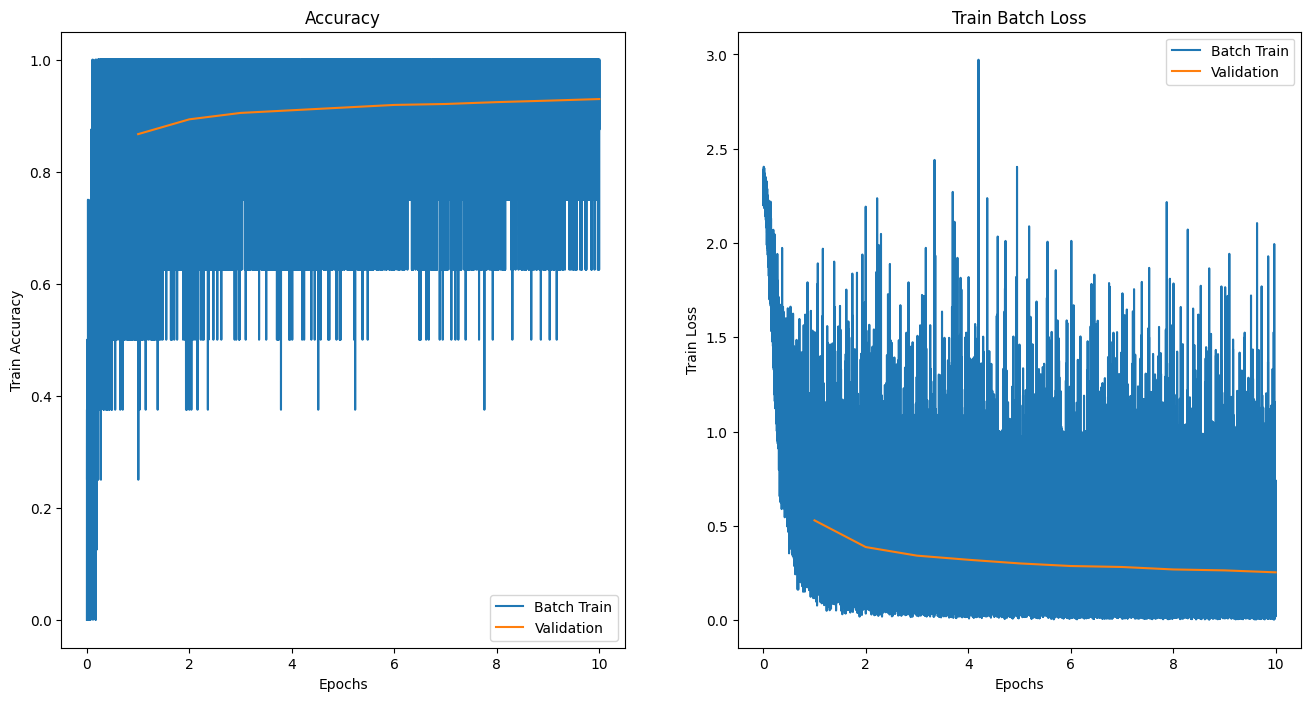

In [904]:
figure = plt.figure(figsize=(16, 8))


figure.add_subplot(1, 2, 1)
plt.plot(train_epoch_no, train_batch_accuracy)
plt.plot(np.arange(1, EPOCHS + 1), valid_batch_accuracy.mean(axis=1))
plt.legend(["Batch Train", "Validation"])
plt.title("Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Train Accuracy")

figure.add_subplot(1, 2, 2)
plt.plot(train_epoch_no, train_batch_loss)
plt.plot(np.arange(1, EPOCHS + 1), valid_batch_loss.mean(axis=1))
plt.legend(["Batch Train", "Validation"])
plt.title("Train Batch Loss")
plt.xlabel("Epochs")
plt.ylabel("Train Loss")


plt.show()

---
# TurbaNet: Swarm-Based Training

TurbaNet is a framework designed to train multiple neural networks **simultaneously** using a swarm-based approach. Instead of training a single model sequentially, TurbaNet **vectorizes the training process**, leveraging hardware efficiency for faster convergence.

### Model Architecture:
Each model in the swarm follows the same **fully connected** architecture:
- **Fully connected neural network** with two hidden layers.
- **ReLU activations** for non-linearity.
- **Softmax output layer** for digit classification (0-9).

### Training Details:
- **Loss Function**: Cross-Entropy Loss
- **Optimizer**: Adam

By training multiple models in parallel, TurbaNet **achieves efficiency gains** over standard PyTorch training, making it ideal for large-scale deep learning tasks.


## Setup Bootstrap Training Dataset 

In [905]:
if BOOTSTRAP_SIZE is None:
    BOOTSTRAP_SIZE = X_train.shape[0]

In [906]:
X_train_turba = np.zeros((BOOTSTRAP_SIZE, SWARM_SIZE))
y_train_turba = np.zeros((BOOTSTRAP_SIZE, SWARM_SIZE))

# Random Bootstrapping with resampling
x = X_train.numpy()
y = y_train.numpy()
for i in range(SWARM_SIZE):
    index = np.random.randint(0, X_train.shape[0], BOOTSTRAP_SIZE)
    X_train_turba[:, i] = index
    y_train_turba[:, i] = index

In [907]:
# Setup bootstrapping of training data
turba_train_dataset = torch.utils.data.TensorDataset(
    torch.Tensor(X_train_turba), torch.Tensor(y_train_turba)
)
turba_train_dataloader = torch.utils.data.DataLoader(
    turba_train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
)

## Model/Optimizer/Loss Definitions

In [908]:
from flax import linen as nn


# Softmax layer ignored since the loss function defined is nn.CrossEntropy()
class Brain(nn.Module):
    @nn.compact
    def __call__(self, x):  # noqa ANN001
        x = nn.Dense(HIDDEN1)(x)
        x = nn.relu(x)
        x = nn.Dense(HIDDEN2)(x)
        x = nn.relu(x)
        x = nn.Dense(10)(x)

        return x


In [909]:
optimizer = optax.adam(learning_rate=LR)

In [910]:
turba_models = TurbaTrainState.swarm(
    Brain(), optimizer, swarm_size=SWARM_SIZE, sample_input=X_train[0]
)

## Helper Functions

In [911]:
from turbanet import softmax_cross_entropy


def turbanet_train(
    X_data: torch.Tensor,
    y_data: torch.Tensor,
    dataloader: torch.utils.data.DataLoader,
    model: TurbaTrainState,
):
    size = 0
    correct = 0

    batch_loss = np.zeros(len(dataloader))
    batch_accuracy = np.zeros(len(dataloader))

    for batch, (X, y) in enumerate(dataloader):
        # Reshape data
        X = X_data[torch.transpose(X, 1, 0).numpy()]
        y = y_data[torch.transpose(y, 1, 0).numpy()]

        # Feedforward / Loss
        model, loss, prediction = model.train(X, y, softmax_cross_entropy)

        # Accuracy
        _correct = (prediction.argmax(axis=2) == y.numpy().argmax(axis=2)).astype(int).sum(axis=1)

        # Updating loss_batch and batch_accuracy
        batch_loss[batch] = loss.mean().item()
        batch_accuracy[batch] = (_correct / X.shape[1]).mean().item()

        # Updating size and correct
        size += X.shape[1]
        correct += _correct

        if batch % 100 == 0:
            loss = loss.mean().item()
            print(f"loss: {loss:>7f}  [{size:>5d}]")

    accuracy = (correct / size).mean().item()
    print(f"Average Train Accuracy: {(100 * accuracy):>0.1f}%")

    return model, batch_loss, batch_accuracy


In [912]:
def turbanet_validation(dataloader, model):
    size = 0
    model_correct = 0
    ensamble_correct = 0

    batch_loss = np.zeros(len(dataloader))
    batch_model_accuracy = np.zeros(len(dataloader))
    batch_ensamble_accuracy = np.zeros(len(dataloader))
    for batch, (X, y) in enumerate(dataloader):
        # Repeat for swarm_size times
        X = np.expand_dims(X.numpy(), 0).repeat(len(model), axis=0)
        y_expanded = np.expand_dims(y.numpy(), 0).repeat(len(model), axis=0)

        # Feedforward / Loss
        loss, prediction = model.evaluate(X, y_expanded, softmax_cross_entropy)

        # Accuracy
        _ensamble_correct = (
            (prediction.mean(axis=0).argmax(axis=1) == y.numpy().argmax(axis=1))
            .astype(int)
            .sum(axis=0)
        )
        _correct = (prediction.argmax(axis=2) == y_expanded.argmax(axis=2)).astype(int).sum(axis=1)

        # Updating loss_batch and batch_accuracy
        batch_loss[batch] = loss.mean().item()
        batch_model_accuracy[batch] = (_correct / X.shape[1]).mean().item()
        batch_ensamble_accuracy[batch] = (_ensamble_correct / X.shape[1]).mean().item()

        # Updating size and correct
        size += X.shape[1]
        model_correct += _correct
        ensamble_correct += _ensamble_correct

    model_accuracy = (model_correct / size).mean().item()
    ensamble_accuracy = (ensamble_correct / size).item()
    print(f"Average Validation Accuracy: {(100 * model_accuracy):>0.1f}%")
    print(f"Ensamble Validation Accuracy: {(100 * ensamble_accuracy):>0.1f}%")

    return batch_loss, batch_model_accuracy, batch_ensamble_accuracy

## Training

In [913]:
start = time.time()
train_epoch_no = []
train_batch_loss = []
train_batch_accuracy = []

for t in range(EPOCHS):
    print(f"Epoch {t + 1}\n-------------------------------")
    turba_models, _train_batch_loss, _train_batch_accuracy = turbanet_train(
        X_train, y_train, turba_train_dataloader, turba_models
    )
    _valid_batch_loss, _valid_model_batch_accuracy, _valid_ensamble_batch_accuracy = (
        turbanet_validation(val_dataloader, turba_models)
    )

    for i in range(len(_train_batch_loss)):
        train_batch_loss.append(_train_batch_loss[i])
        train_batch_accuracy.append(_train_batch_accuracy[i])
        train_epoch_no.append(t + float((i + 1) / len(_train_batch_loss)))

    if t == 0:
        valid_batch_loss = _valid_batch_loss
        valid_model_batch_accuracy = _valid_model_batch_accuracy
        valid_ensamble_batch_accuracy = _valid_ensamble_batch_accuracy
    else:
        valid_batch_loss = np.vstack((valid_batch_loss, _valid_batch_loss))
        valid_model_batch_accuracy = np.vstack(
            (valid_model_batch_accuracy, _valid_model_batch_accuracy)
        )
        valid_ensamble_batch_accuracy = np.vstack(
            (valid_ensamble_batch_accuracy, _valid_ensamble_batch_accuracy)
        )

turba_time = time.time() - start
print(f"turba time: {turba_time}")

Epoch 1
-------------------------------
loss: 2.325365  [    8]
loss: 2.227537  [  808]
loss: 2.167610  [ 1608]
loss: 2.048897  [ 2408]
loss: 1.938128  [ 3208]
loss: 1.826934  [ 4008]
loss: 1.728622  [ 4808]
loss: 1.575063  [ 5608]
loss: 1.551615  [ 6408]
loss: 1.373785  [ 7208]
loss: 1.294561  [ 8008]
loss: 1.219295  [ 8808]
loss: 1.106073  [ 9608]
loss: 1.008066  [10408]
loss: 1.003735  [11208]
loss: 0.907779  [12008]
loss: 0.883192  [12808]
loss: 0.884300  [13608]
loss: 0.791636  [14408]
loss: 0.804477  [15208]
loss: 0.740193  [16008]
loss: 0.746981  [16808]
loss: 0.636206  [17608]
loss: 0.729261  [18408]
loss: 0.624688  [19208]
loss: 0.626877  [20008]
loss: 0.601067  [20808]
loss: 0.597895  [21608]
loss: 0.581572  [22408]
loss: 0.554692  [23208]
loss: 0.614726  [24008]
loss: 0.523946  [24808]
loss: 0.554685  [25608]
loss: 0.484374  [26408]
loss: 0.477178  [27208]
loss: 0.521741  [28008]
loss: 0.485038  [28808]
loss: 0.456473  [29608]
loss: 0.508801  [30408]
loss: 0.432074  [31208]


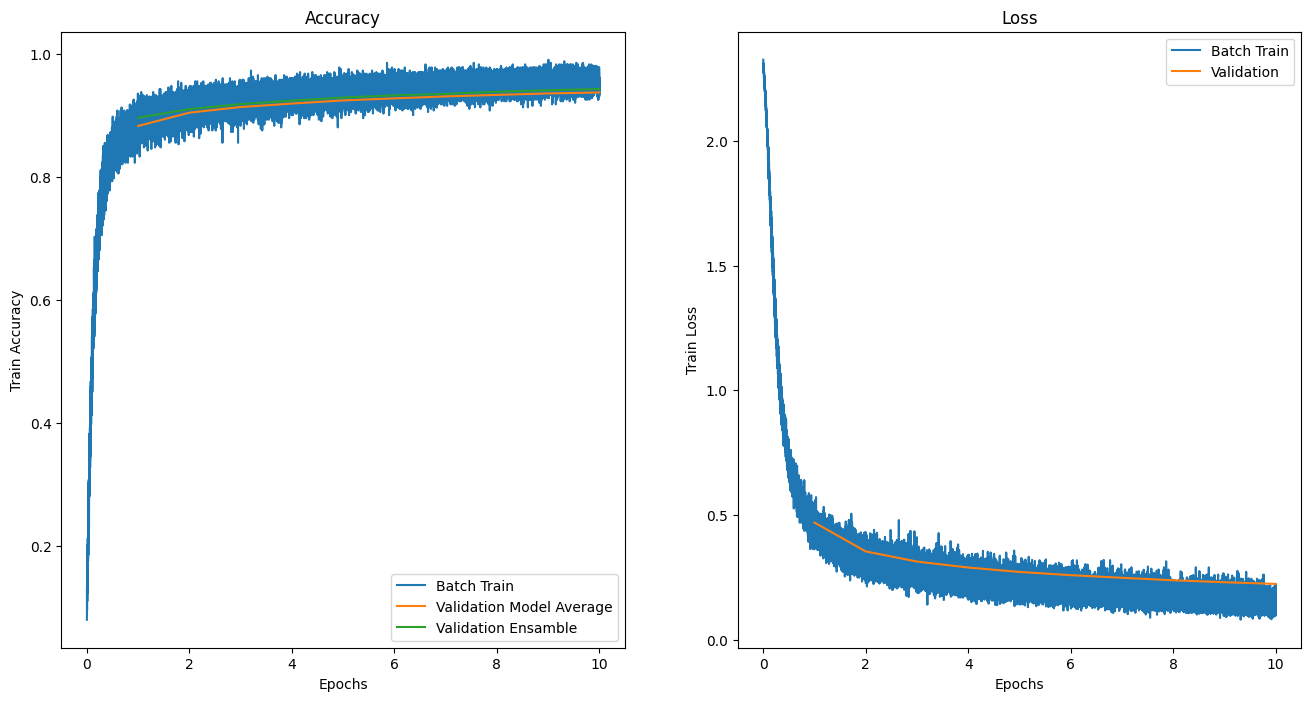

In [914]:
figure = plt.figure(figsize=(16, 8))


figure.add_subplot(1, 2, 1)
plt.plot(train_epoch_no, train_batch_accuracy)
plt.plot(np.arange(1, EPOCHS + 1), valid_model_batch_accuracy.mean(axis=1))
plt.plot(np.arange(1, EPOCHS + 1), valid_ensamble_batch_accuracy.mean(axis=1))
plt.legend(["Batch Train", "Validation Model Average", "Validation Ensamble"])
plt.title("Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Train Accuracy")

figure.add_subplot(1, 2, 2)
plt.plot(train_epoch_no, train_batch_loss)
plt.plot(np.arange(1, EPOCHS + 1), valid_batch_loss.mean(axis=1))
plt.legend(["Batch Train", "Validation"])
plt.title("Loss")
plt.xlabel("Epochs")
plt.ylabel("Train Loss")


plt.show()

# Results Comparison

## Torch on Test Set

In [915]:
# Run Torch model on test set
torch_y_pred = np.empty((0, 1))
torch_y_true = np.empty((0, 1))
for batch, (X, y) in enumerate(test_dataloader):
    X, y = X.to(DEVICE), y.to(DEVICE)
    pred = torch_model(X)
    torch_y_pred = np.append(torch_y_pred, pred.argmax(1).cpu().numpy().reshape(-1, 1), axis=0)
    torch_y_true = np.append(torch_y_true, y.argmax(1).cpu().numpy().reshape(-1, 1), axis=0)

# Total accuracy on test set
torch_accuracy = (torch_y_pred == torch_y_true).mean()
torch_precision = precision_score(torch_y_true, torch_y_pred, average="macro")
torch_recall = recall_score(torch_y_true, torch_y_pred, average="macro")
torch_f1 = f1_score(torch_y_true, torch_y_pred, average="macro")
print("PyTorch")
print(f"Accuracy: {(100 * torch_accuracy):>0.1f}%")
print(f"Precision: {(100 * torch_precision):>0.1f}%")
print(f"Recall: {(100 * torch_recall):>0.1f}%")
print(f"F1: {(100 * torch_f1):>0.1f}%")

PyTorch
Accuracy: 92.9%
Precision: 92.8%
Recall: 92.8%
F1: 92.8%


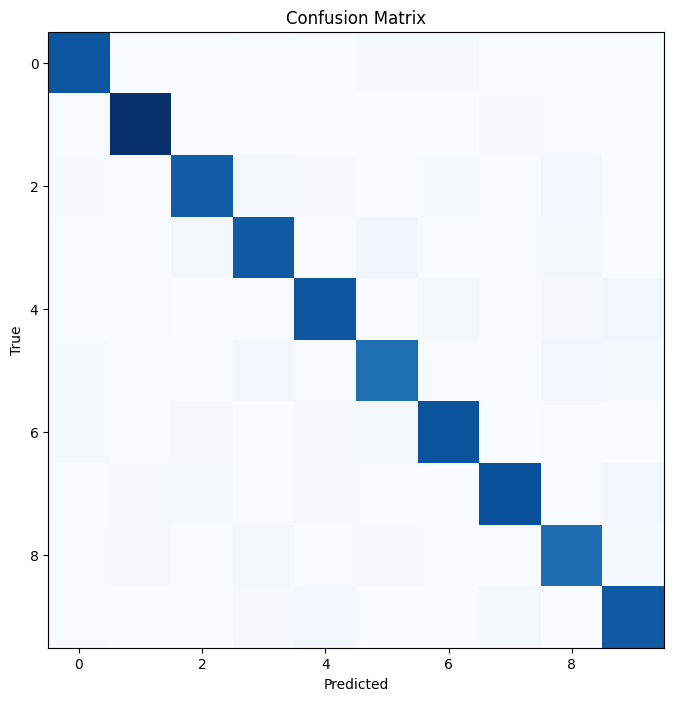

In [916]:
# Plot confusion matrix
cm = confusion_matrix(torch_y_true, torch_y_pred, labels=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

figure = plt.figure(figsize=(8, 8))

ax = figure.add_subplot(1, 1, 1)

ax.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)
ax.set_title("Confusion Matrix")
ax.set_xlabel("Predicted")
ax.set_ylabel("True")

plt.show()

## Turba on Test Set

In [917]:
# Run Turba models on test set
turba_y_pred_models = np.empty((SWARM_SIZE, 0))
turba_y_pred_ensamble = np.empty((0, 0))
turba_y_true = np.empty((0, 0))
for X, y in test_dataloader:
    X = np.expand_dims(X.numpy(), 0).repeat(len(turba_models), axis=0)
    y = np.expand_dims(y.numpy(), 0).repeat(len(turba_models), axis=0)

    prediction = turba_models.predict(X)
    model_predictions = prediction.argmax(axis=2)
    ensamble_prediction = prediction.mean(axis=0).argmax(axis=1)
    truth = np.argmax(y[0], axis=1)

    turba_y_pred_models = np.append(turba_y_pred_models, model_predictions, axis=1)
    turba_y_pred_ensamble = np.append(turba_y_pred_ensamble, ensamble_prediction)
    turba_y_true = np.append(turba_y_true, truth)

# Average total accuracy on test set
turba_model_accuracies = (turba_y_pred_models == turba_y_true).mean(axis=1)
turba_model_precisions = [
    precision_score(turba_y_true, turba_y_pred_models[i], average="macro")
    for i in range(SWARM_SIZE)
]
turba_model_recalls = [
    recall_score(turba_y_true, turba_y_pred_models[i], average="macro") for i in range(SWARM_SIZE)
]
turba_model_f1s = [
    f1_score(turba_y_true, turba_y_pred_models[i], average="macro") for i in range(SWARM_SIZE)
]
turba_model_accuracy = np.mean(turba_model_accuracies)
turba_model_precision = np.mean(turba_model_precisions)
turba_model_recall = np.mean(turba_model_recalls)
turba_model_f1 = np.mean(turba_model_f1s)
print("Average Model")
print(f"Accuracy: {(100 * np.mean(turba_model_accuracy)):>0.1f}%")
print(f"Precision: {(100 * np.mean(turba_model_precision)):>0.1f}%")
print(f"Recall: {(100 * np.mean(turba_model_recall)):>0.1f}%")
print(f"F1: {(100 * np.mean(turba_model_f1)):>0.1f}%")

turba_ensamble_accuracy = (turba_y_pred_ensamble == turba_y_true).mean()
turba_ensamble_precision = precision_score(turba_y_true, turba_y_pred_ensamble, average="macro")
turba_ensamble_recall = recall_score(turba_y_true, turba_y_pred_ensamble, average="macro")
turba_ensamble_f1 = f1_score(turba_y_true, turba_y_pred_ensamble, average="macro")
print("\nEnsamble")
print(f"Accuracy: {(100 * np.mean(turba_ensamble_accuracy)):>0.1f}%")
print(f"Precision: {(100 * np.mean(turba_ensamble_precision)):>0.1f}%")
print(f"Recall: {(100 * np.mean(turba_ensamble_recall)):>0.1f}%")
print(f"F1: {(100 * np.mean(turba_ensamble_f1)):>0.1f}%")

Average Model
Accuracy: 93.8%
Precision: 93.7%
Recall: 93.7%
F1: 93.7%

Ensamble
Accuracy: 94.4%
Precision: 94.4%
Recall: 94.4%
F1: 94.4%


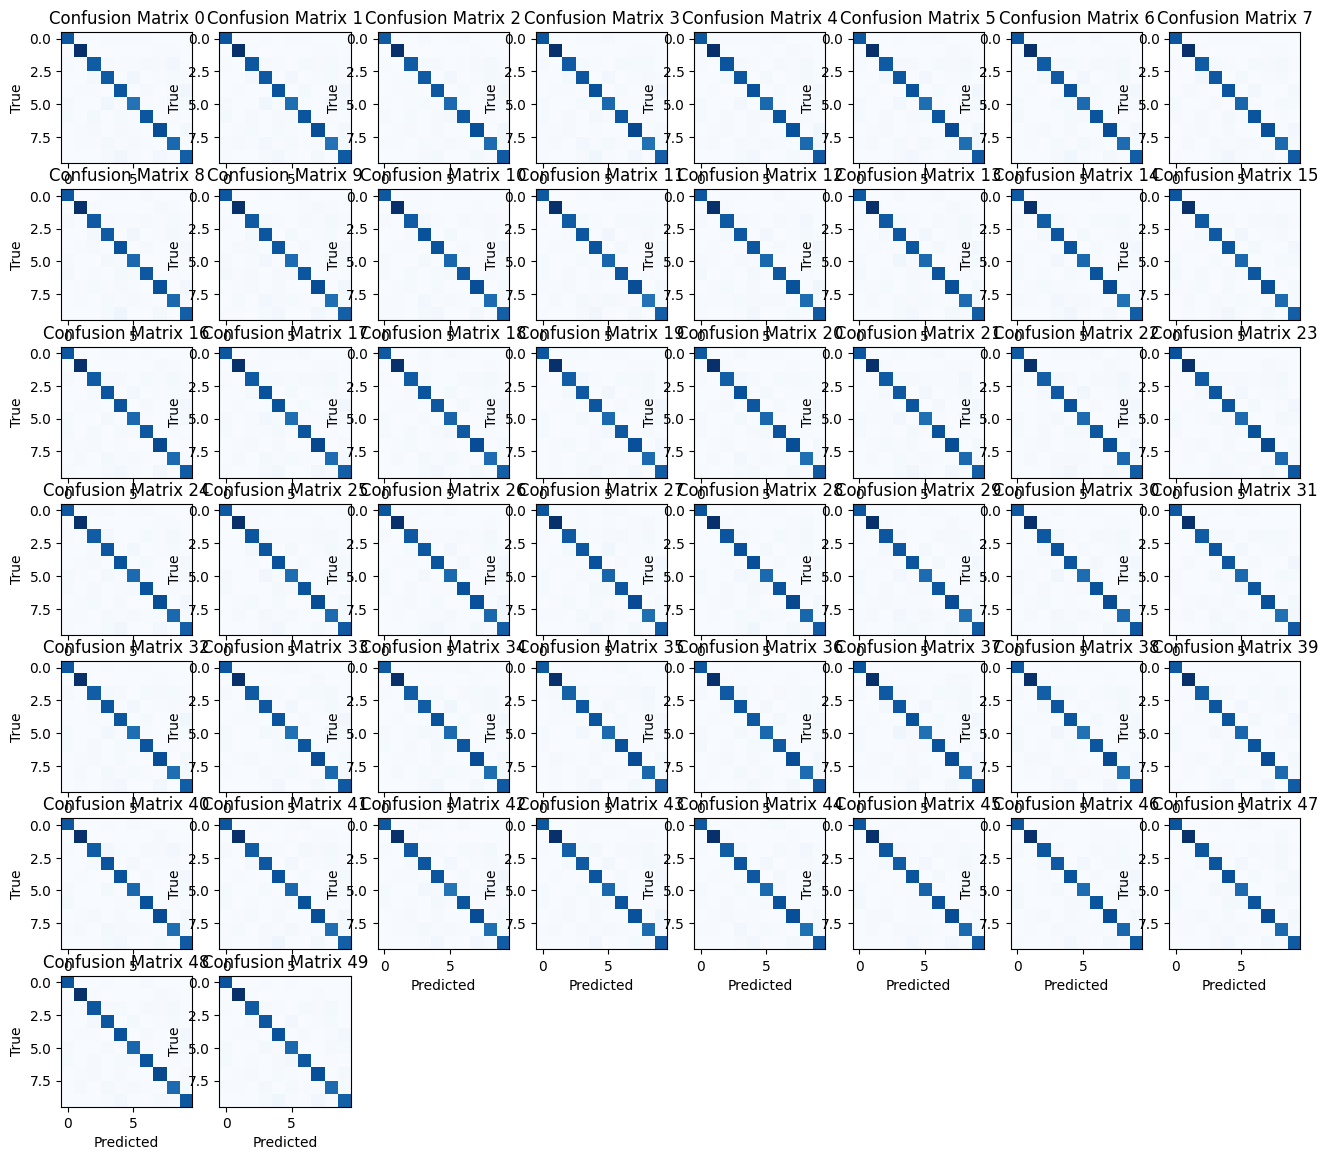

In [918]:
# Subplot of predictions vs ground truth (x by x)
fig = plt.figure(figsize=(16, 16))

# Shared axes
for i in range(SWARM_SIZE):
    ax = fig.add_subplot(
        int(np.ceil(np.sqrt(SWARM_SIZE))), int(np.ceil(np.sqrt(SWARM_SIZE))), i + 1
    )

    # Confusion matrix
    cm = confusion_matrix(
        turba_y_true, turba_y_pred_models[i], labels=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
    )
    ax.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)

    # Labels
    ax.set_title(f"Confusion Matrix {i}")
    ax.set_xlabel("Predicted")
    ax.set_ylabel("True")

plt.show()

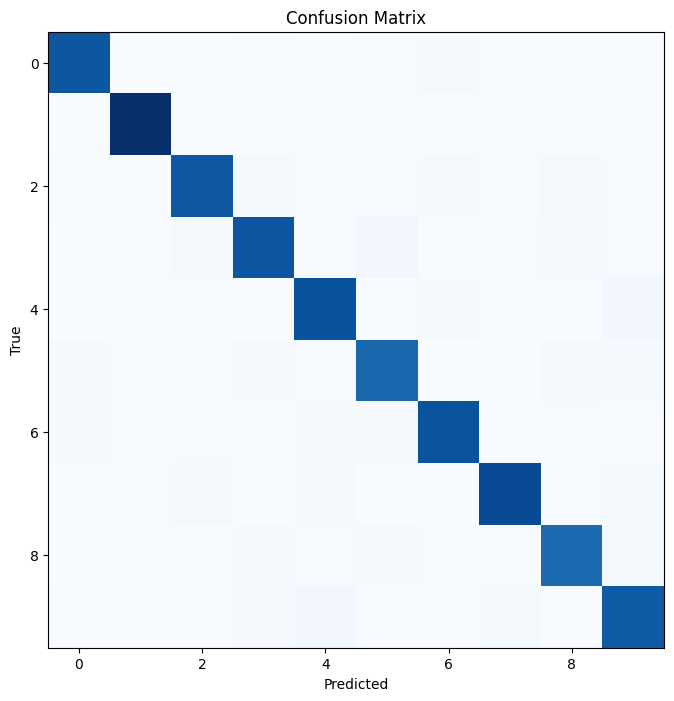

In [919]:
# Plot confusion matrix
cm = confusion_matrix(turba_y_true, turba_y_pred_ensamble, labels=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

figure = plt.figure(figsize=(8, 8))

ax = figure.add_subplot(1, 1, 1)

ax.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)
ax.set_title("Confusion Matrix")
ax.set_xlabel("Predicted")
ax.set_ylabel("True")

plt.show()

## Torch v. Turba

In [920]:
# Confusion Matrix for PyTorch
cm_pytorch = confusion_matrix(torch_y_true, torch_y_pred)

# Confusion Matrix for TurbaNet (Average across models)
cm_turbanet_models = sum(
    confusion_matrix(turba_y_true, pred) for pred in turba_y_pred_models
) / len(turba_models)

# Confusion Matrix for TurbaNet (Ensamble)
cm_turbanet_ensamble = confusion_matrix(turba_y_true, turba_y_pred_ensamble)

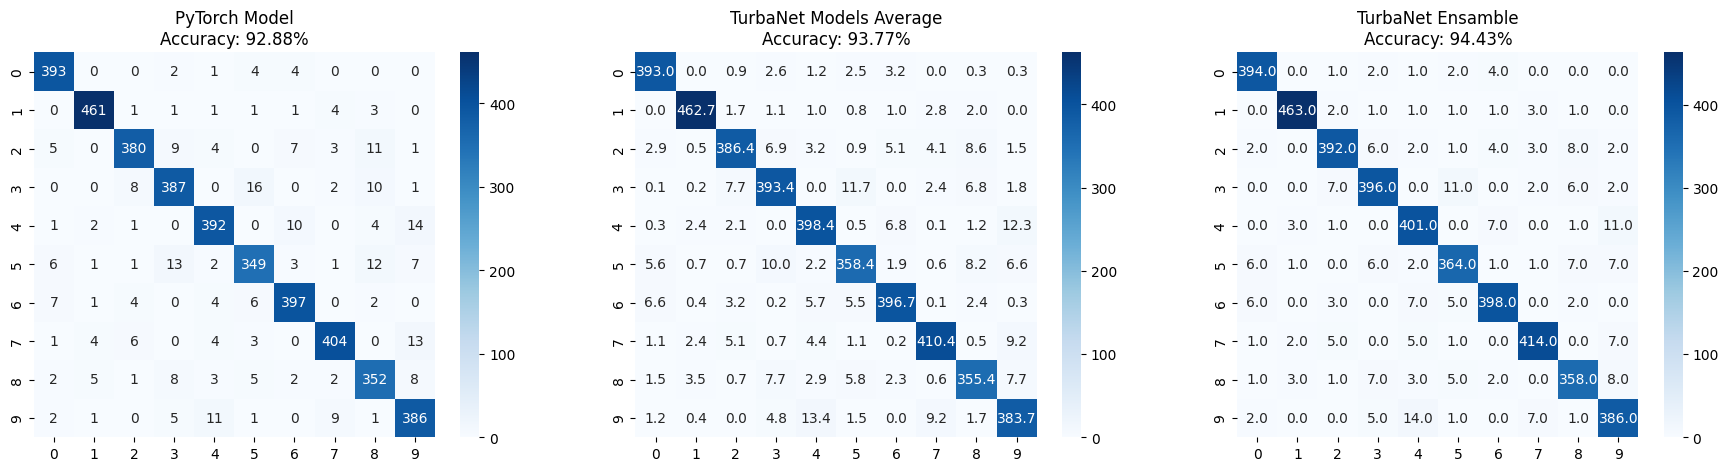

In [921]:
# Plot comparison
fig, axes = plt.subplots(1, 3, figsize=(22, 5))

sns.heatmap(cm_pytorch, annot=True, fmt="d", cmap="Blues", ax=axes[0])
axes[0].set_title(f"PyTorch Model\nAccuracy: {torch_accuracy:.2%}")

sns.heatmap(cm_turbanet_models, annot=True, fmt=".1f", cmap="Blues", ax=axes[1])
axes[1].set_title(f"TurbaNet Models Average\nAccuracy: {turba_model_accuracy:.2%}")

sns.heatmap(cm_turbanet_ensamble, annot=True, fmt=".1f", cmap="Blues", ax=axes[2])
axes[2].set_title(f"TurbaNet Ensamble\nAccuracy: {turba_ensamble_accuracy:.2%}")

plt.show()


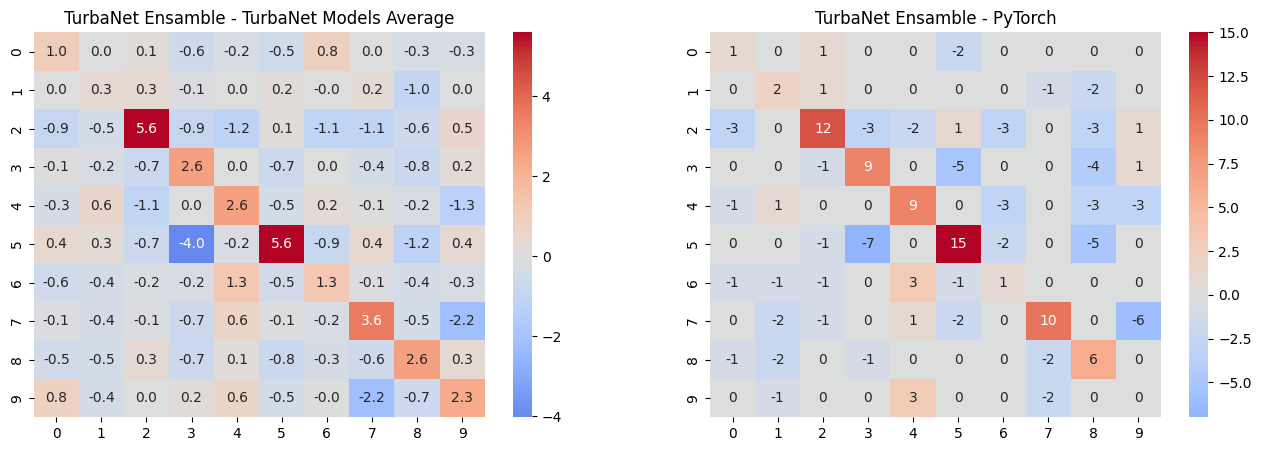

In [922]:
# Plot comparison
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Difference between TurbaNet (Average across models) and TurbaNet Ensamble
diff = cm_turbanet_ensamble - cm_turbanet_models
sns.heatmap(diff, annot=True, fmt=".1f", cmap="coolwarm", ax=axes[0], center=0)
axes[0].set_title("TurbaNet Ensamble - TurbaNet Models Average")

# Difference between PyTorch and TurbaNet Ensamble
diff = cm_turbanet_ensamble - cm_pytorch
sns.heatmap(diff, annot=True, fmt="d", cmap="coolwarm", ax=axes[1], center=0)
axes[1].set_title("TurbaNet Ensamble - PyTorch")

plt.show()


In [923]:
from IPython.core.display import display_functions, HTML

output = """
====================================================================================
Model       Training Time    Accuracy    Precision      Recall      F1-Score
====================================================================================
PyTorch       {:.2f} sec     {:>6.1f}%      {:>6.1f}%      {:>6.1f}%      {:>6.1f}%
------------------------------------------------------------------------------------
Turba (Avg)   {:.2f} sec     {:>6.1f}%      {:>6.1f}%      {:>6.1f}%      {:>6.1f}%
Turba (Ens)   ------        {:>6.1f}%      {:>6.1f}%      {:>6.1f}%      {:>6.1f}%
====================================================================================
""".format(
    torch_time,
    100 * torch_accuracy,
    100 * torch_precision,
    100 * torch_recall,
    100 * torch_f1,
    turba_time,
    100 * turba_model_accuracy,
    100 * turba_model_precision,
    100 * turba_model_recall,
    100 * turba_model_f1,
    100 * turba_ensamble_accuracy,
    100 * turba_ensamble_precision,
    100 * turba_ensamble_recall,
    100 * turba_ensamble_f1,
)

display_functions.display(HTML(f"<pre>{output}</pre>"))